In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import os.path
from os import path
import subprocess


In [2]:
## Remove the daily trend at every point
def subtract_trend(x):

    doy = np.unique(x['time.dayofyear'])
    
#     if(doy % 100 == 0):
#         print('detrending day of year = ' + str(doy))
    
    detrendOrder = 3

    curve = np.polynomial.polynomial.polyfit(np.arange(0,x.shape[0]),x,detrendOrder)
    trend = np.polynomial.polynomial.polyval(np.arange(0,x.shape[0]), curve, tensor=True)
    detrend = x - np.swapaxes(trend,0,1)
    detrend = detrend.astype('float32')

    return detrend



In [3]:
def correct_eof_sign(eof1,eof2):

    f = '/Users/nicojg/Documents/Work/2021_Fall_IAI/Data/Index_EOFS/example_MJO_eofs_waccm2.pkl' # use this one for historical and SSP simulations with CESM2-WACCM
#     f = 'index_eofs/example_MJO_eofs.pkl' # old one
#     f = 'index_eofs/example_MJO_eofs_waccm3.pkl' # this one doesn't work
    eof_df = pd.read_pickle(f)

    # the indexing from [:180*2] is so that we only grab the winds and not precip for the correlation
    
    c11 = np.corrcoef(eof_df['eof1'][:180*2].values,eof1[:180*2])[0,1]
    c22 = np.corrcoef(eof_df['eof2'][:180*2].values,eof2[:180*2])[0,1]

    c12 = np.corrcoef(eof_df['eof1'][:180*2].values,eof2[:180*2])[0,1]
    c21 = np.corrcoef(eof_df['eof2'][:180*2].values,eof1[:180*2])[0,1]

    print(c11,c22,c12,c21)

    if(np.abs(c12)+np.abs(c21) > np.abs(c11)+np.abs(c22)):
        eof1_updated = np.copy(eof2)
        eof2_updated = np.copy(eof1)
    else:
        eof1_updated = np.copy(eof1)
        eof2_updated = np.copy(eof2)

    c11 = np.corrcoef(eof_df['eof1'][:180*2].values,eof1_updated[:180*2])[0,1]
    c22 = np.corrcoef(eof_df['eof2'][:180*2].values,eof2_updated[:180*2])[0,1]
    print(c11,c22)

    if(c11<0):
        eof1_updated = eof1_updated*-1
    if(c22<0):
        eof2_updated = eof2_updated*-1

    c11 = np.corrcoef(eof_df['eof1'][:180*2].values,eof1_updated[:180*2])[0,1]
    c22 = np.corrcoef(eof_df['eof2'][:180*2].values,eof2_updated[:180*2])[0,1]
    print(c11,c22)
    
    # return eof1_updated, eof2_updated, eof_df['eof1'], eof_df['eof2']
    return eof2, eof1, eof_df['eof1'], eof_df['eof2']

For the MJO calculation we use precipitation, zonal winds at 250 and 850. All 3 variables have the same lat-lon grid and time values.

In [4]:

wind_var = 'ua'


open_dir = '/Users/nicojg/Documents/Work/2021_Fall_IAI/Code/TLLTT/data/'
# save_dir = '/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2020/Causality_CESM2-WACCM/indices/savedIndices/'

filename1 = 'mjocalc_uwinds_200_250.nc'
filename2 = 'mjocalc_uwinds_200_850.nc'
filename3 = 'mjocalc_years200_precip.nc'

loadfile1 = open_dir+filename1
loadfile2 = open_dir+filename2
loadfile3 = open_dir+filename3

# grab data vectors
print('opening...' + loadfile1)
print('opening...' + loadfile2)
print('opening...' + loadfile3)

ds1 = xr.open_dataset(loadfile1)['ua']
ds2 = xr.open_dataset(loadfile2)['ua']
ds3 = xr.open_dataset(loadfile3)['pr']# * 86400

# try:
#     latvar = 'lat'
#     lonvar = 'lon'
#     lat = ds1.coords[latvar]
#     lon = ds1.coords[lonvar]
# except:
#     latvar = 'LAT'
#     lonvar = 'LON'
#     lat = ds1.coords[latvar]
#     lon = ds1.coords[lonvar]

latvar = 'lat'
lonvar = 'lon'

lat  = xr.open_dataset(loadfile1)[latvar].values#[96:]
lon   = xr.open_dataset(loadfile1)[lonvar].values#[80:241]

tropics_idx = np.squeeze(np.where((lat>= -15) & (lat <=15)))        

u250 = ds1[:,0,tropics_idx,:]
u850 = ds2[:,0,tropics_idx,:]
pr = ds3[:,tropics_idx,:]

print("done")




opening.../Users/nicojg/Documents/Work/2021_Fall_IAI/Code/TLLTT/data/mjocalc_uwinds_200_250.nc
opening.../Users/nicojg/Documents/Work/2021_Fall_IAI/Code/TLLTT/data/mjocalc_uwinds_200_850.nc
opening.../Users/nicojg/Documents/Work/2021_Fall_IAI/Code/TLLTT/data/mjocalc_years200_precip.nc
done


taking tropical mean...
<xarray.DataArray 'ua' (time: 73120, lat: 32, lon: 288)>
[673873920 values with dtype=float32]
Coordinates:
  * time     (time) object 0200-09-03 00:00:00 ... 0400-12-31 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
    plev     float64 2.5e+04
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    units:          m s-1
    cell_measures:  area: areacella
    cell_methods:   time: mean
    comment:        Zonal wind (positive in a eastward direction).
    description:    Zonal wind (positive in a eastward direction).
    frequency:      day
    id:             ua
    mipTable:       day
    out_name:       ua
    prov:           day ((isd.003))
    realm:          atmos
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Eastward Wind
    type:           real
   

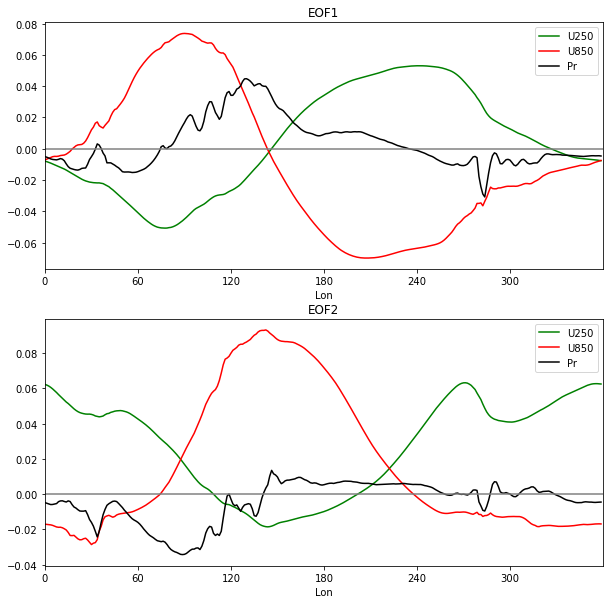

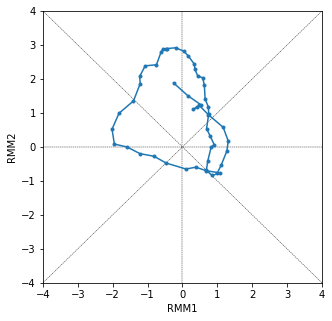

[1.32029084 1.19266432 0.97435549 ... 1.58326846 1.73282808 1.81432362]
8.0
1.0
(73000,)
179.9987305815622
-179.99766402742077
saved /Users/nicojg/Documents/Work/2021_Fall_IAI/Data/Index_EOFS/MJO_CESM2-piControl_intialTEST.pkl


In [5]:
#================================================================
# Loop through 40-year chunks
#================================================================            
# for chunkstart in np.arange(int(date_range[0:4]),2100,int(chunkLen_yrs/4)):

#     chunkend = chunkstart + chunkLen_yrs - 1
#     print('Chunk Years = ' + str(chunkstart) + '-' + str(chunkend))
#     chunkName = str(chunkstart) + '-' + str(chunkend)

#     index_savename = save_dir + 'MJO_CESM2-WACCM_' + period + '_'+ensemble_member+'_' + chunkName + '.pkl'
#     if(path.exists(index_savename)==True):
#         print('file exists')
#         #continue
    
#     lat_avg_u250 = u250.sel(time=slice(str(chunkstart) + '-01-01', str(chunkend) + '-12-31'))
#     lat_avg_u850 = u850.sel(time=slice(str(chunkstart) + '-01-01', str(chunkend) + '-12-31'))
#     lat_avg_pr = pr.sel(time=slice(str(chunkstart) + '-01-01', str(chunkend) + '-12-31'))
    
print('taking tropical mean...')
print(print(u250))
lat_avg_u250 = u250.mean(dim = latvar, skipna = True) # skips the missing values - I think xarray does this by default
lat_avg_u850 = u850.mean(dim = latvar, skipna = True) 
lat_avg_pr = pr.mean(dim = latvar, skipna = True)             


# if(len(np.unique(lat_avg_u250['time.year'])) != chunkLen_yrs):
#     print('breaking the loop....')
#     break

time = lat_avg_u250['time']

    #================================================================ 
    # REMOVE THE POLYNOMIAL TREND
    #================================================================ 
print('removing polynomial trend')
lat_avg_u250 = lat_avg_u250.groupby('time.dayofyear').map(subtract_trend)
lat_avg_u850 = lat_avg_u850.groupby('time.dayofyear').map(subtract_trend)
lat_avg_pr = lat_avg_pr.groupby('time.dayofyear').map(subtract_trend)        

    #================================================================ 
    # START SAVINIS ANALYSIS
    #================================================================ 

#             print('removing seasonal cycle')
#             u250_clim = lat_avg_u250.groupby('time.dayofyear').mean('time')
#             u850_clim = lat_avg_u850.groupby('time.dayofyear').mean('time')
#             pr_clim = lat_avg_pr.groupby('time.dayofyear').mean('time')

#             ft_u250 = np.fft.fft(u250_clim.values, axis  = 0)
#             ft_u850 = np.fft.fft(u850_clim.values, axis  = 0)
#             ft_pr = np.fft.fft(pr_clim.values, axis  = 0)

#             ft_u250[4:-3,:] = 0.0 # mean and first 3 harmonics remain
#             ft_u850[4:-3,:] = 0.0 
#             ft_pr[4:-3,:] = 0.0

#             lowpass_sig_u250 = np.real(np.fft.ifft(ft_u250, axis = 0))
#             lowpass_sig_u850 = np.real(np.fft.ifft(ft_u850, axis = 0))
#             lowpass_sig_pr = np.real(np.fft.ifft(ft_pr, axis = 0))

#             plt.figure(figsize=(20,10))
#             for i in range(7):    
#                 plt.subplot(2,7,i+1)
#                 plt.plot(np.arange(0,365),u850_clim[:,20*i],'-k', label = 'data', linewidth = 3)
#                 plt.plot(np.arange(0,365), lowpass_sig_u850[:,20*i],'-r',linewidth = 3)
#             plt.show()

#             for i in range((np.shape(time)[0])//365):
#                 lat_avg_u250[i*365:(i+1)*365,:] -= lowpass_sig_u250[:,:]
#                 lat_avg_u850[i*365:(i+1)*365,:] -= lowpass_sig_u850[:,:]
#                 lat_avg_pr[i*365:(i+1)*365,:] -= lowpass_sig_pr[:,:]

# #             plot raw anomalous time series
#             plt.figure(figsize=(20,10))
#             for i in range(5):    
#                 X = lat_avg_pr[:,20*i]
#                 plt.subplot(2,5,i+1)
#                 plt.plot((X-np.mean(X))[:2000],'-k', linewidth = .25)
#                 plt.axhline(y=0,color='gray')

#             plt.show()

u250_drm = np.apply_along_axis(np.convolve, 0, lat_avg_u250, np.ones(120)/120, mode='same') # the mean of the first 120 days 
# stored at index 60
print(u250_drm.shape)
u850_drm = np.apply_along_axis(np.convolve, 0, lat_avg_u850, np.ones(120)/120, mode='same')
print(u850_drm.shape)
pr_drm = np.apply_along_axis(np.convolve, 0, lat_avg_pr, np.ones(120)/120, mode='same')
print(pr_drm.shape)

lat_avg_u250[120:,:] -= u250_drm[60:-60, :] # you want to deduct the mean of the previous 120 days
lat_avg_u850[120:,:] -= u850_drm[60:-60, :]
lat_avg_pr[120:,:] -= pr_drm[60:-60, :]

#             Need to discard the first 120 time steps of the data because of this preprocessing step.

preprocess_u250 = lat_avg_u250[120:,:]
preprocess_u850 = lat_avg_u850[120:,:]
preprocess_pr = lat_avg_pr[120:,:]

#             Standardize the data.

norm_u250 = (preprocess_u250 - np.mean(preprocess_u250))/np.std(preprocess_u250)
norm_u850 = (preprocess_u850 - np.mean(preprocess_u850))/np.std(preprocess_u850)
norm_pr = (preprocess_pr - np.mean(preprocess_pr))/np.std(preprocess_pr)

print('computing EOFs')
X_pca = np.hstack((norm_u250, norm_u850, norm_pr))

print(norm_u250.shape)
print(norm_u850.shape)
print(norm_pr.shape)


N_time = np.shape(X_pca)[0]

# X_pca = np.squeeze(np.asarray(X_pca))

C = (1./N_time) * np.dot(np.transpose(X_pca),X_pca) # C is a real symmetric matrix
lam, Z = np.linalg.eig(C)

lam = np.real(lam) # this should always be real technically
i = np.flipud(np.argsort(lam))
lam = lam[i]
pve = 100.*lam/np.sum(lam)
Z = Z[:,i]
lead_eig1 = np.real(Z[:,0])
lead_eig2 = np.real(Z[:,1])

print('percent (%) variance explained...')
print(pve[:5])


# figure out EOF signs
#-------------------------------------------
N_lon = len(lon)
eof1,eof2,baseeof1,baseeof2 = correct_eof_sign(lead_eig1,lead_eig2)      
#             if(ensemble_member=='r3i1p1f1'):
#                 if(chunkstart==1860 or chunkstart==1870 or chunkstart==1880 or chunkstart==1890):
#                     eof1, eof2 = eof2*-1, eof1
#             elif(ensemble_member=='r2i1p1f1'):
#                 if(chunkstart==1870 or chunkstart==1910):
#                     eof1, eof2 = eof2*-1, eof1
#-------------------------------------------
a = .35
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
print("len of N_lon: " + str(len(lon)))

print("Shape of EOF1: "+ str(eof1.shape))
print("Shape of base EOF1: "+ str(baseeof1.shape))

plt.plot(lon,eof1[:N_lon],'green', label='U250')
plt.plot(lon,eof1[N_lon:2*N_lon],'r', label='U850')
plt.plot(lon,eof1[2*N_lon: 3*N_lon], 'k',label='Pr')
# plt.plot(lon,baseeof1[:N_lon],'green', label='U250', alpha=a)
# plt.plot(lon,baseeof1[N_lon:2*N_lon],'r', label='U850', alpha=a)
# plt.plot(lon,baseeof1[2*N_lon: 3*N_lon], 'k',label='Pr', alpha=a)

plt.axhline(y=0,color='gray')
plt.xlim((0,360))
plt.xticks(np.arange(0,360,step = 60))
plt.legend()
plt.title('EOF1')
plt.xlabel('Lon')

plt.subplot(2,1,2)
plt.plot(lon,eof2[:N_lon], 'green',label='U250')
plt.plot(lon,eof2[N_lon:2*N_lon],'r', label='U850')
plt.plot(lon,eof2[2*N_lon: 3*N_lon],'k', label='Pr')
# plt.plot(lon,baseeof2[:N_lon], 'green',label='U250', alpha=a)
# plt.plot(lon,baseeof2[N_lon:2*N_lon],'r', label='U850', alpha=a)
# plt.plot(lon,baseeof2[2*N_lon: 3*N_lon],'k', label='Pr', alpha=a)

plt.xlim((0,360))
plt.axhline(y=0,color='gray')
plt.legend()
plt.xticks(np.arange(0,360,step = 60))
plt.xlabel('Lon')
plt.title('EOF2')

# plot_filename = save_dir + '../processingCode/index_figures/' + 'MJO_EOF1_EOF2_'+period+'_'+ensemble_member+'_'+chunkName +'.png'
# plt.savefig(plot_filename, dpi=300)
plt.show()
            

# save eof data
eof_df = pd.DataFrame({'eof1':eof1,'eof2':eof2})
# eof_df.to_pickle('index_eofs/MJO_EOF1_EOF2_'+period+'_'+ensemble_member+'_'+chunkName + '.pkl')
eof_df.to_pickle('/Users/nicojg/Documents/Work/2021_Fall_IAI/Data/Index_EOFS/init_test_MJO_EOF1_EOF2_piControl.pkl')

pc1 = np.dot(X_pca,eof1)
pc2 = np.dot(X_pca,eof2)

rmm1 = (pc1 - np.mean(pc1))/np.std(pc1)
rmm2 = (pc2 - np.mean(pc2))/np.std(pc2)

fig=plt.figure(figsize = (5,5))
ax=fig.add_subplot(1,1,1)

plt.plot([-4,4],[-4,4],linewidth=0.4,linestyle='--',color='k')
plt.plot([-4,4],[4,-4],linewidth=0.4,linestyle='--',color='k')
plt.plot([-4,4],[0,0],linewidth=0.4,linestyle='--',color='k')
plt.plot([0,0],[-4,4],linewidth=0.4,linestyle='--',color='k')

plt.xlim([-4.0,4.0])
plt.ylim([-4.0,4.0])
plt.plot(rmm1[:50],rmm2[:50],'.-')
plt.xlabel('RMM1')
plt.ylabel('RMM2')
plt.show()
plt.close('all')

mjo_amp = np.sqrt(np.square(rmm1) + np.square(rmm2))

mjo_cts_angle = np.arctan2(rmm2,rmm1) * 180 / np.pi

mjo_discrete_angle = np.ceil((mjo_cts_angle+180)/45)

print(mjo_amp)

print(np.max(mjo_discrete_angle))
print(np.min(mjo_discrete_angle))

print(mjo_cts_angle.shape)

print(np.max(mjo_cts_angle))
print(np.min(mjo_cts_angle))

mjo_time = time[120:]

mjo_time.dt.year

# print(mjo_time)

mjo_df = pd.DataFrame({'PC1':pc1,'PC2':pc2,'RMM1':rmm1, 'RMM2':rmm2, 'Phase':mjo_discrete_angle, 'Year':mjo_time.dt.year, 'Month':mjo_time.dt.month, 'Day': mjo_time.dt.day})
#         mjo_df
index_savename = "/Users/nicojg/Documents/Work/2021_Fall_IAI/Data/Index_EOFS/" + 'MJO_CESM2-piControl_intialTEST.pkl'
mjo_df.to_pickle(index_savename)             
print('saved ' + index_savename)
